In [1]:
import talk.config as con

con.config_configManager()
con.config_matplotlib()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Constructing estimators 
------------------------
https://en.wikipedia.org/wiki/Autoregressive_model

#### Thomas Schmelzer

A very common estimator is based on AR models (autoregressive)

$$R_T = \sum_{i=1}^n w_i r_{T-i}$$

Predict the (unknown) return $R_T$ using the last $n$ previous returns. **Attention**: You may want to use volatility adjusted returns, apply filters etc.
 
How to pick the $n$ free parameters in $\mathbf{w}$? (Partial) autocorrelations? 



In [2]:
def convolution(ts, weights):
    from statsmodels.tsa.filters.filtertools import convolution_filter
    return convolution_filter(ts, weights, nsides=1)

In [3]:
import pandas as pd

r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [2.0, 1.0]
# trendfollowing == positive weights
x=pd.DataFrame()
x["r"] = r
x["pred"] = convolution(r, weights)
x["before"] = x["pred"].shift(1)
print(x)
print(x.corr())

     r  pred  before
0  1.0   NaN     NaN
1 -2.0  -3.0     NaN
2  1.0   0.0    -3.0
3  1.0   3.0     0.0
4  1.5   4.0     3.0
5  0.0   1.5     4.0
6  2.0   4.0     1.5
               r      pred    before
r       1.000000  0.895788 -0.190159
pred    0.895788  1.000000  0.538431
before -0.190159  0.538431  1.000000


In [4]:
import pandas as pd

# mean-reversion == negative weights
r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [-2.0, -1.0]
x=pd.DataFrame()
x["r"] = r
x["pred"] = convolution(r, weights)
x["before"] = x["pred"].shift(1)
print(x)
print(x.corr())

     r  pred  before
0  1.0   NaN     NaN
1 -2.0   3.0     NaN
2  1.0   0.0     3.0
3  1.0  -3.0     0.0
4  1.5  -4.0    -3.0
5  0.0  -1.5    -4.0
6  2.0  -4.0    -1.5
               r      pred    before
r       1.000000 -0.895788  0.190159
pred   -0.895788  1.000000  0.538431
before  0.190159  0.538431  1.000000


## Looking only at the last two returns might be a bit ...

Is it a good idea to have $n=200$ free parameters?



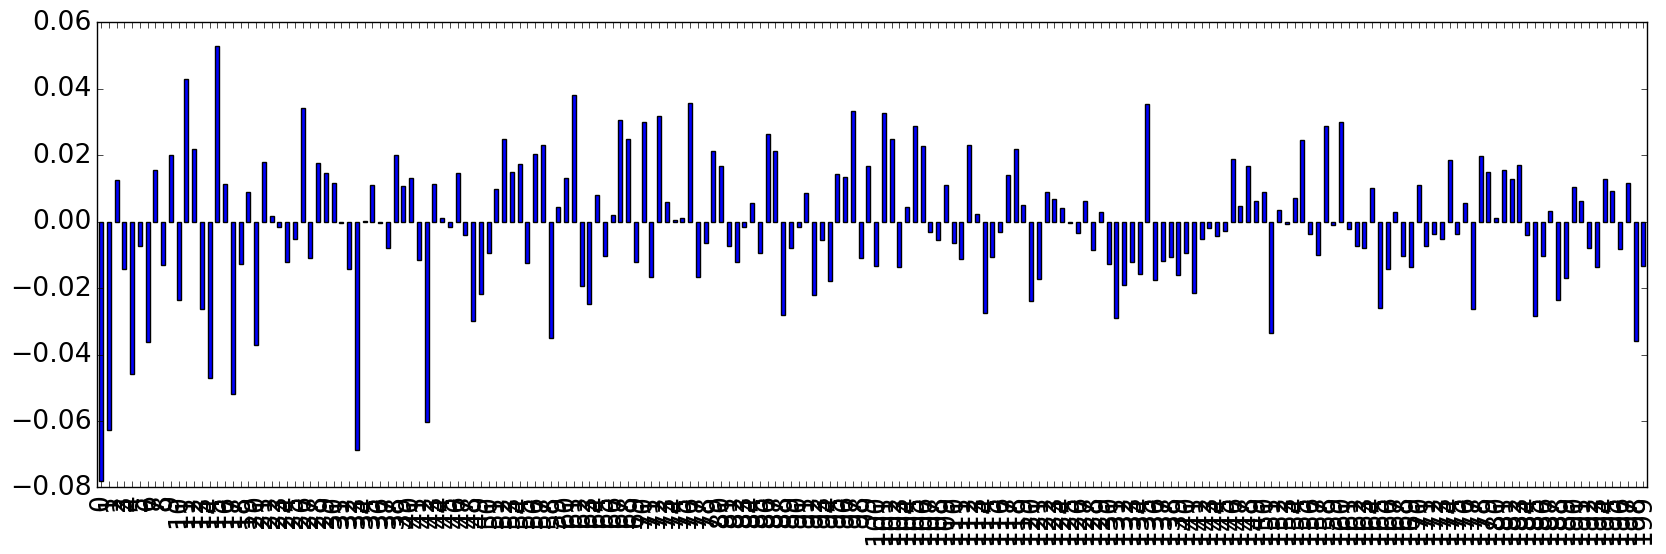

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
# generate random returns
import pandas as pd
r = pd.read_csv("data/SPX_Index.csv", squeeze=True, index_col=0, parse_dates=True).pct_change().dropna()
# let's compute the optimal convolution!
weights = sts.pacf(r, nlags=200)
pd.Series(data=weights[1:]).plot(kind="bar")
plt.show()

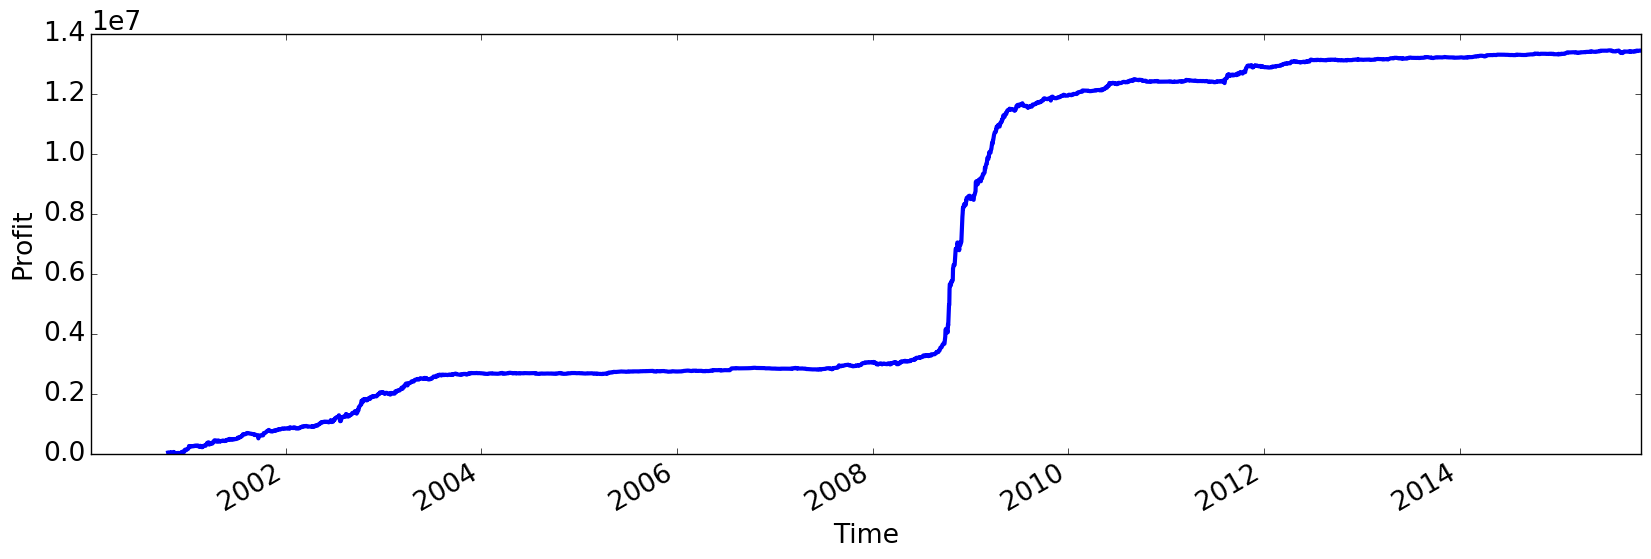

In [6]:
# The trading system! 
pos = convolution(r, weights[1:])
pos = 1e6*(pos/pos.std())
# profit = return[today] * position[yesterday]
(r*pos.shift(1)).cumsum().plot()
plt.xlabel('Time'), plt.ylabel('Profit')
plt.show()

Bias
----

We assume the weights are exponentially decaying, e.g.

$$w_i = \frac{1}{S}\lambda^i$$

where $S$ is a suitable scaling constant and $\lambda = 1-1/N$. Note that $N \neq n$.

**Everything** that is **not** an exponentially weighted moving average is **wrong**.


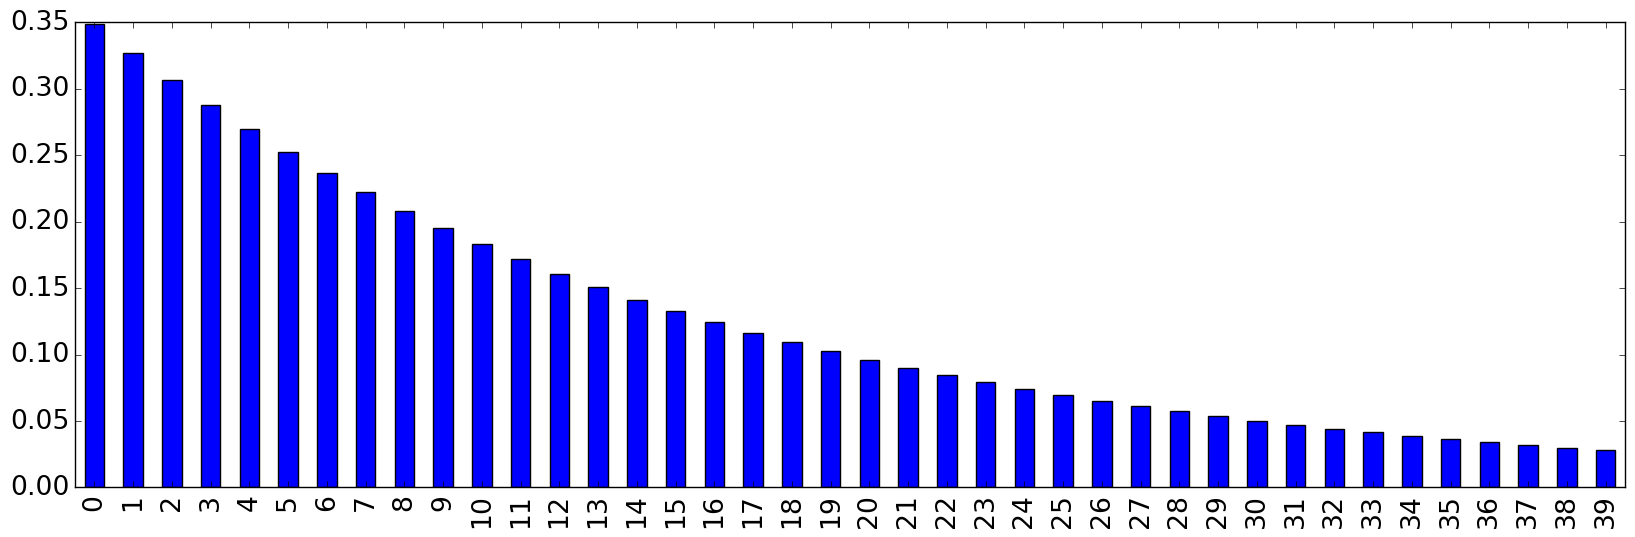

In [7]:
import numpy as np

def exp_weights(m, n=100):
    x = np.power(1.0 - 1.0/m, range(1,n+1))
    S = np.linalg.norm(x)
    return x/S

pd.Series(exp_weights(m=16,n=40)).plot(kind="bar")
plt.show()

In [8]:
import numpy as np
import pandas as pd

periods = [2,4,6,8,12,16,24,32,48,64,96,192]
# matrix of weights
W = pd.DataFrame({period : exp_weights(m=period, n=200) for period in periods}) 
W.plot()

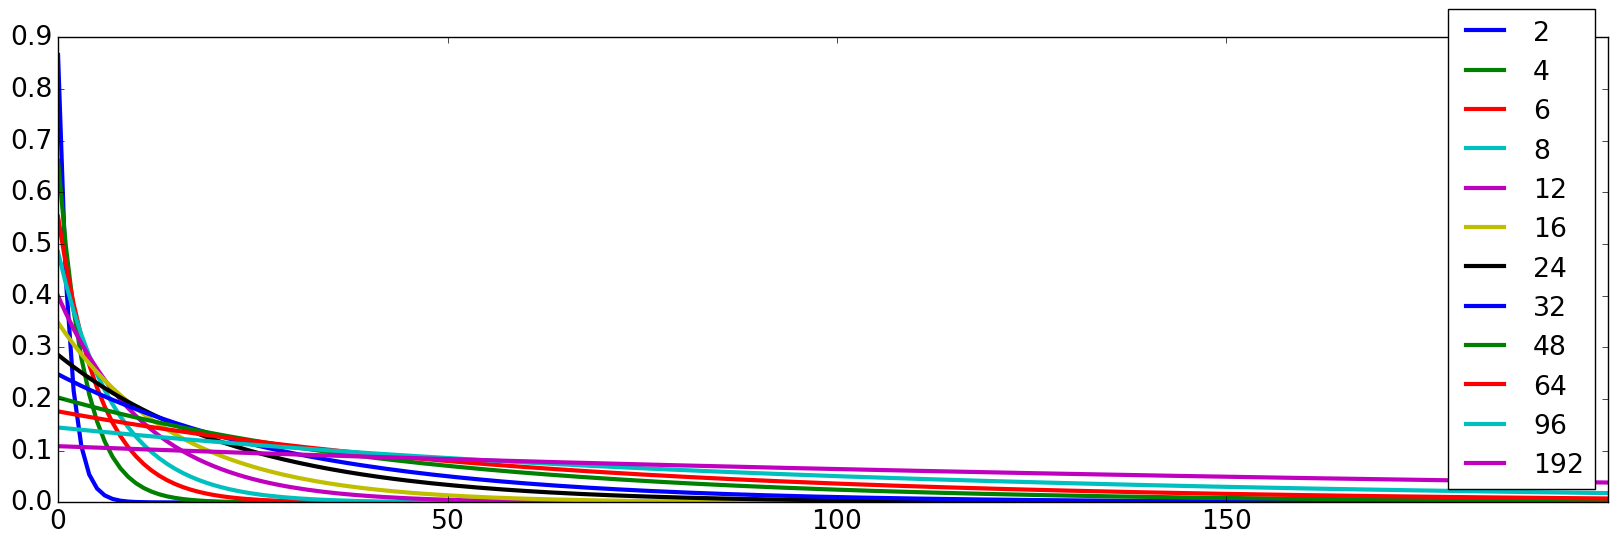

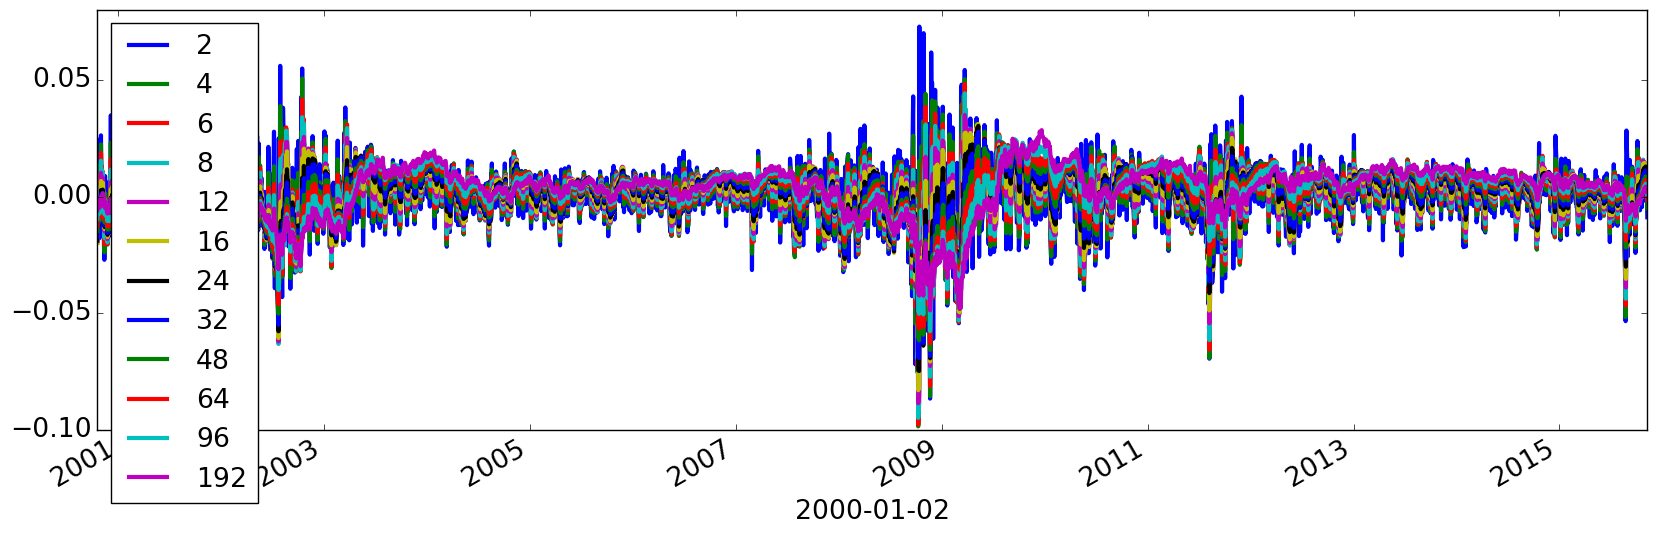

In [9]:
# each column of A is a convoluted return time series
A = pd.DataFrame({period : convolution(r, W[period]).shift(1) for period in periods})  

A = A.dropna(axis=0)
r = r[A.index].dropna()

A.plot()
plt.show()

(Naive) regression
-------------------

\begin{align}
\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w} - \mathbf{r}}\lVert_2 
\end{align}

2       -0.483518
4        8.391620
6      -57.972138
8      140.641232
12    -337.078780
16     499.437196
24    -605.732209
32     477.885878
48     -38.231327
64    -217.640728
96     167.438090
192    -36.934243
dtype: float64


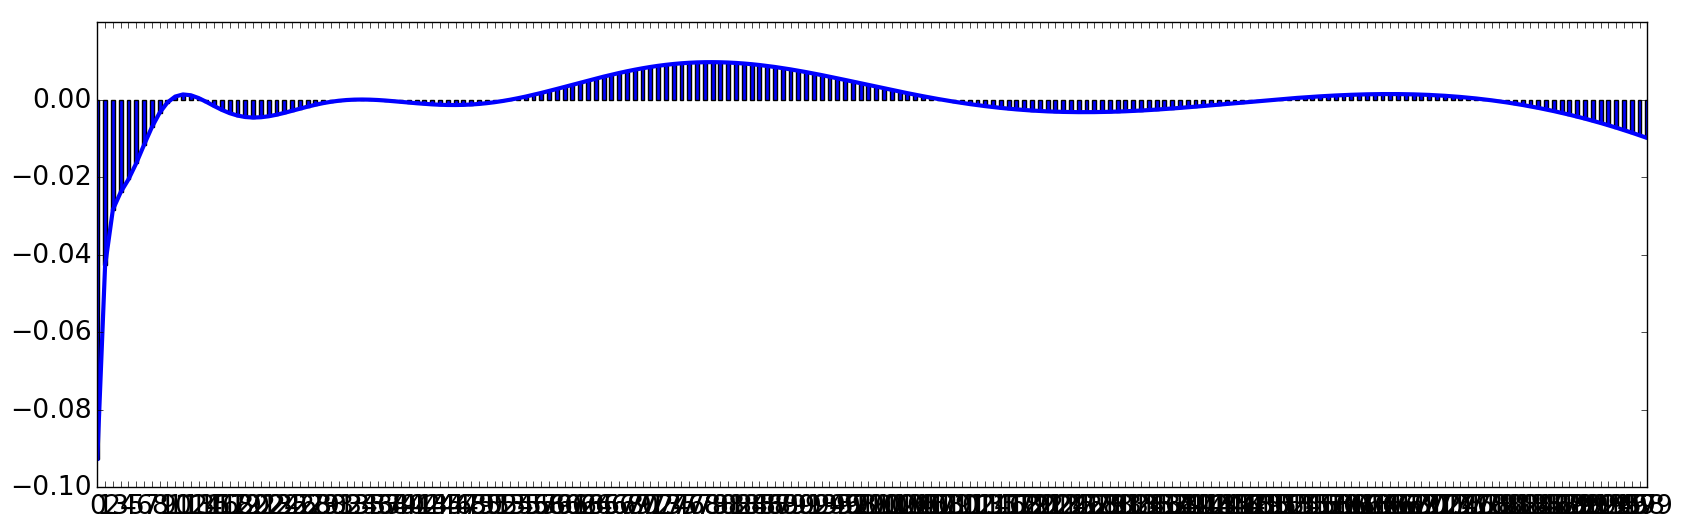

In [10]:
from numpy.linalg import lstsq
# sometimes you don't need to use MOSEK :-)
weights = pd.Series(index=periods, data=lstsq(A.values, r.values)[0])
print(weights)
(W*weights).sum(axis=1).plot(kind="bar")
(W*weights).sum(axis=1).plot()
plt.show()

### Mean variation

We provide a few indicators. Avoid fast indicators. Prefer slower indicators as they induce less trading costs.
Use the mean variation of the signal (convoluted returns here)

$$f(\mathbf{x}) = \frac{1}{n}\sum{\lvert x_i - x_{i-1}\rvert}=\frac{1}{n}\rVert{\Delta \mathbf{x}}\lVert_1$$

The $i$th column of $\mathbf{A}$ has a mean variation $d_i$. We introduce the diagonal penalty matrix $\mathbf{D}$ with $D_{i,i}=d_i$.

$$\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m} \lVert{\mathbf{Aw}-\mathbf{r}}\rVert_2 + \lambda \rVert{\mathbf{Dw}}\lVert_1$$

In [11]:
def mean_variation(ts):
    return ts.diff().abs().mean()

d = A.apply(mean_variation)
D = np.diag(d)
    
from mosek.fusion import *
# but you could use Mosek: 
def __two_norm(model, v):
    # add variable to model for the 2-norm of the residual
    x = model.variable(1, Domain.greaterThan(0.0))
    # add the quadratic cone
    model.constraint(Expr.vstack(x,v), Domain.inQCone())
    return x


def __one_norm(model, v):
    t = model.variable(int(v.size()), Domain.greaterThan(0.0))
    model.constraint(Expr.hstack(t, v), Domain.inQCone(int(v.size()), 2))
    return Expr.sum(t)


def ar(A, D, r, lamb=0.0):

    with Model('lasso') as model:
        n = int(A.shape[1])
        # introduce the variable for the var
        x = model.variable("x", n, Domain.unbounded())
        # minimization of the conditional value at risk
        a1 = __two_norm(model, Expr.sub(Expr.mul(Matrix.dense(A),x), Expr.constTerm(r)))
        a2 = __one_norm(model, Expr.mul(Matrix.dense(D),x))
        
        model.objective(ObjectiveSense.Minimize, Expr.add(a1, Expr.mul(a2, float(lamb))))
        model.solve()

        return x.level()

2       -0.483518
4        8.391620
6      -57.972137
8      140.641229
12    -337.078770
16     499.437176
24    -605.732166
32     477.885814
48     -38.231246
64    -217.640797
96     167.438115
192    -36.934246
dtype: float64


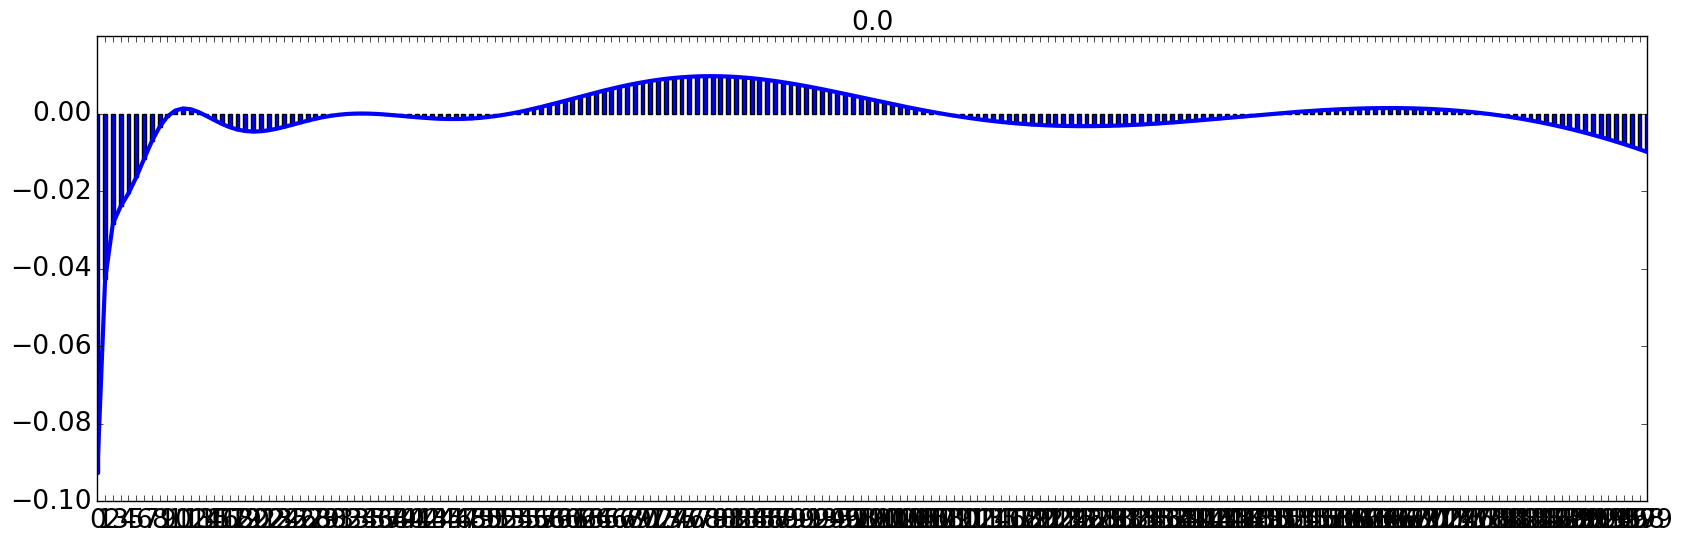

2     -0.051296
4     -0.038511
6     -0.000025
8     -0.000016
12    -0.000025
16    -0.015786
24    -0.001587
32    -0.000016
48    -0.000002
64     0.000005
96     0.000047
192    0.013709
dtype: float64


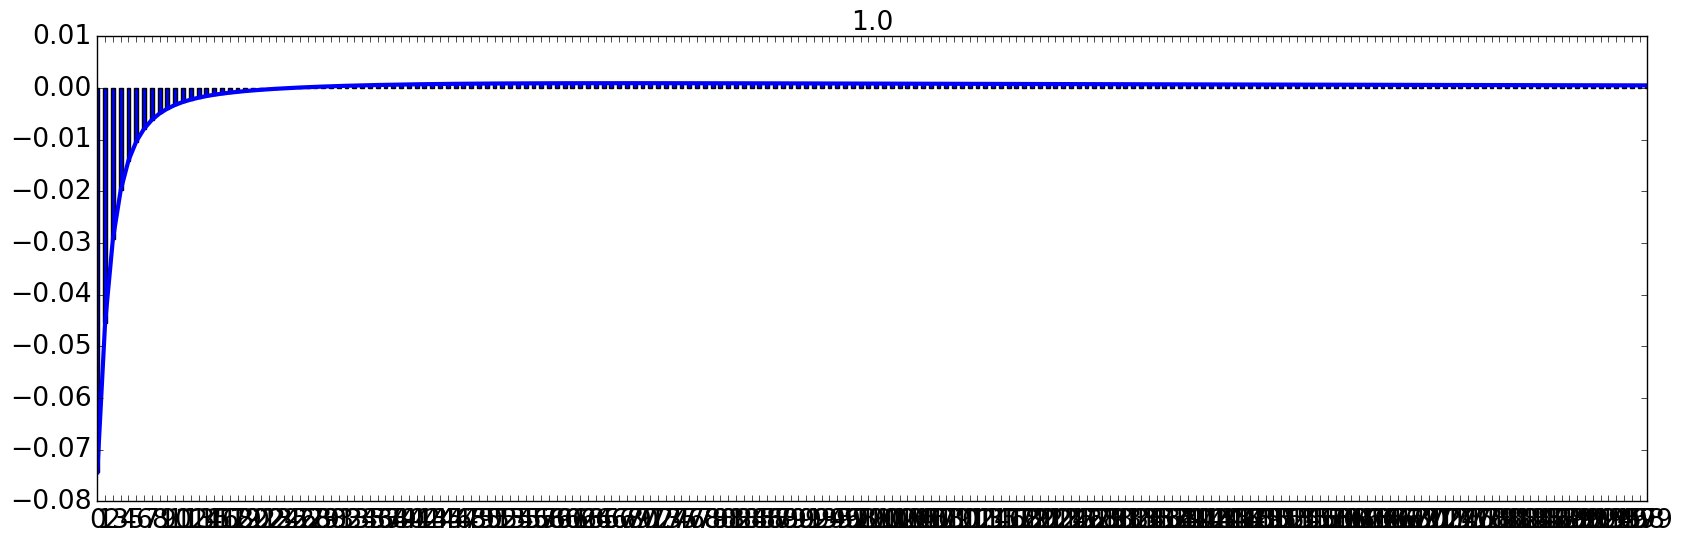

2     -1.677293e-02
4     -6.992491e-02
6     -7.688049e-06
8     -5.482539e-06
12    -7.202979e-06
16    -3.735837e-03
24    -3.369557e-06
32    -3.693263e-06
48    -9.552473e-07
64     1.236953e-07
96     2.526669e-06
192    6.671365e-03
dtype: float64


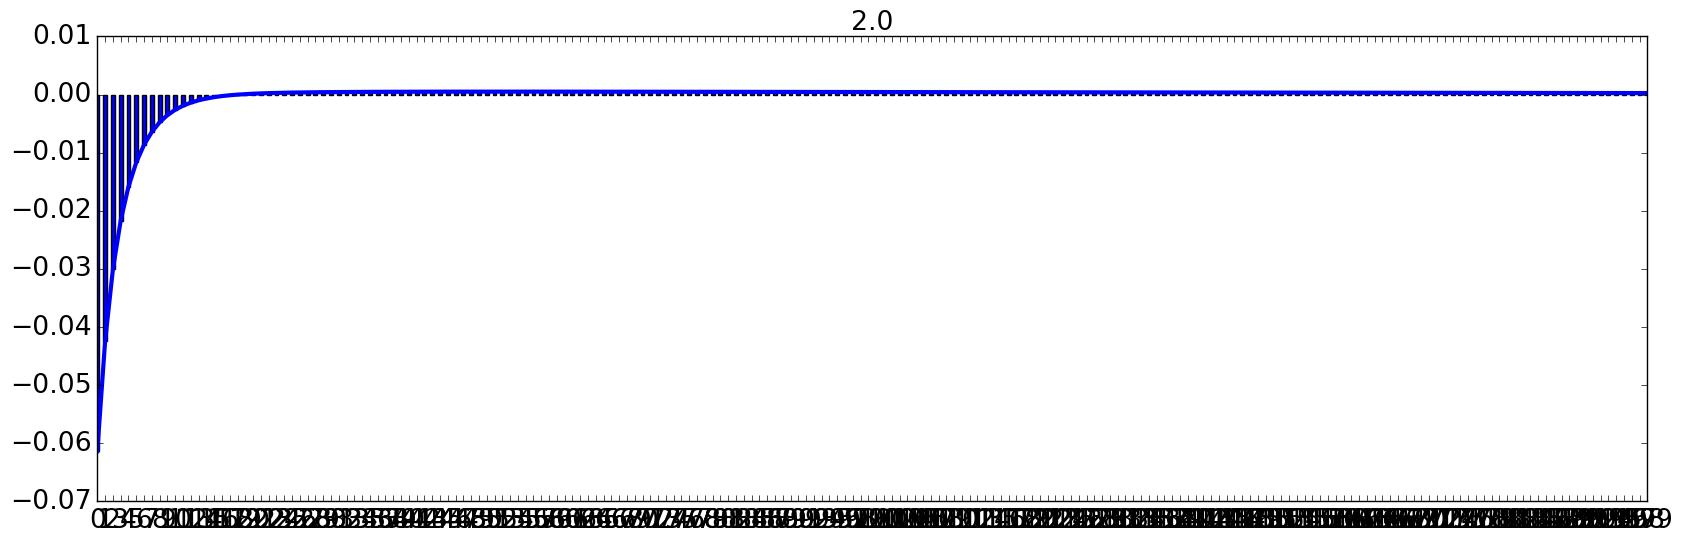

2     -1.416213e-05
4     -7.761505e-02
6     -5.524952e-05
8     -3.342969e-05
12    -4.137081e-05
16    -6.474388e-05
24    -2.339135e-05
32    -9.797724e-06
48    -3.150517e-06
64     2.649569e-08
96     6.528326e-06
192    1.931073e-03
dtype: float64


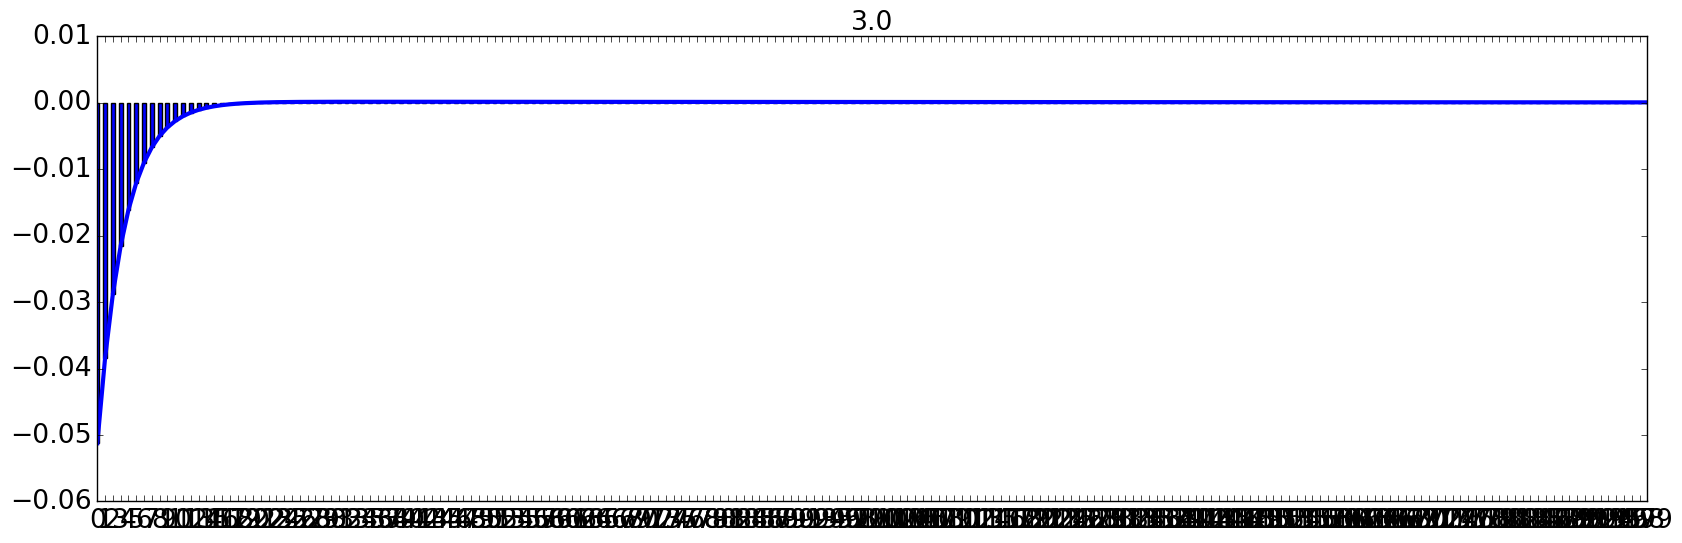

2     -1.256133e-05
4     -1.257897e-02
6     -4.750308e-02
8     -2.769424e-05
12    -1.630707e-05
16    -1.469366e-05
24    -1.559549e-05
32    -1.201238e-05
48    -5.525894e-06
64    -8.666557e-07
96     6.863471e-06
192    2.614161e-05
dtype: float64


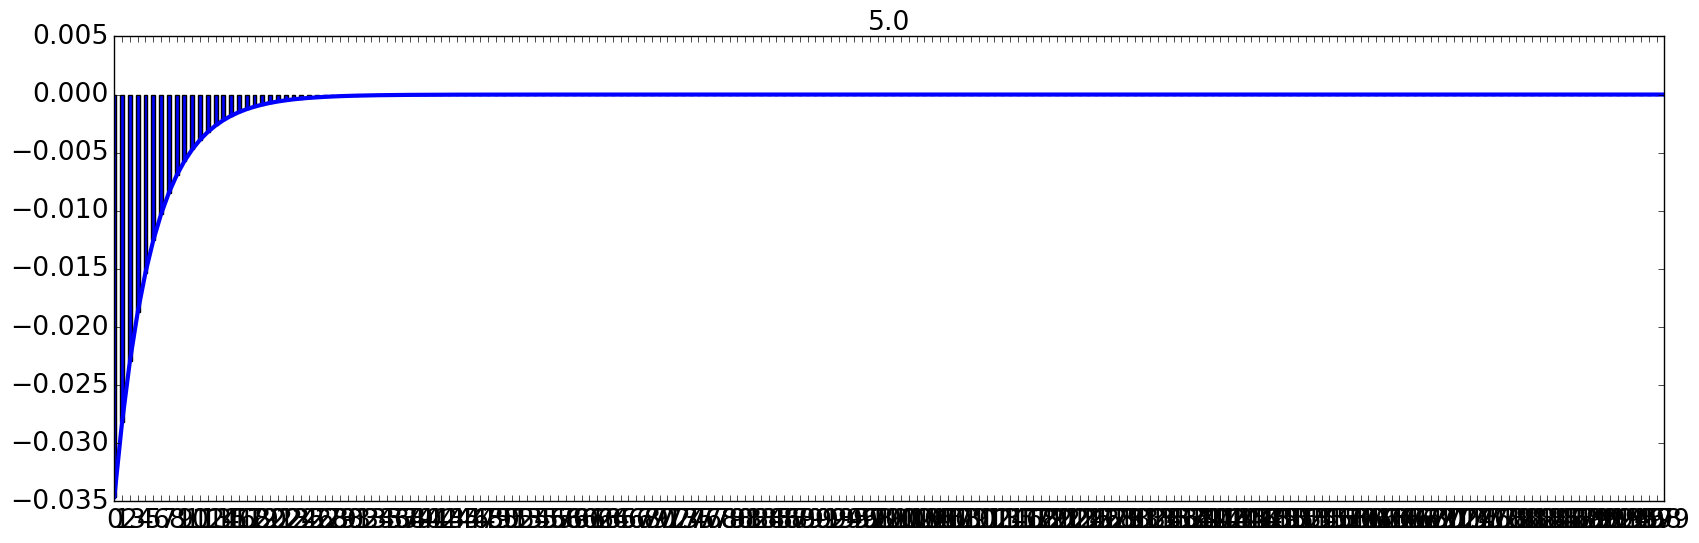

2     -3.789591e-07
4     -3.666965e-06
6     -9.800631e-03
8     -3.472160e-02
12    -4.193236e-06
16    -3.854192e-06
24    -2.133836e-06
32    -1.318665e-06
48    -7.244581e-07
64    -4.608819e-07
96    -1.524892e-07
192    2.092740e-07
dtype: float64


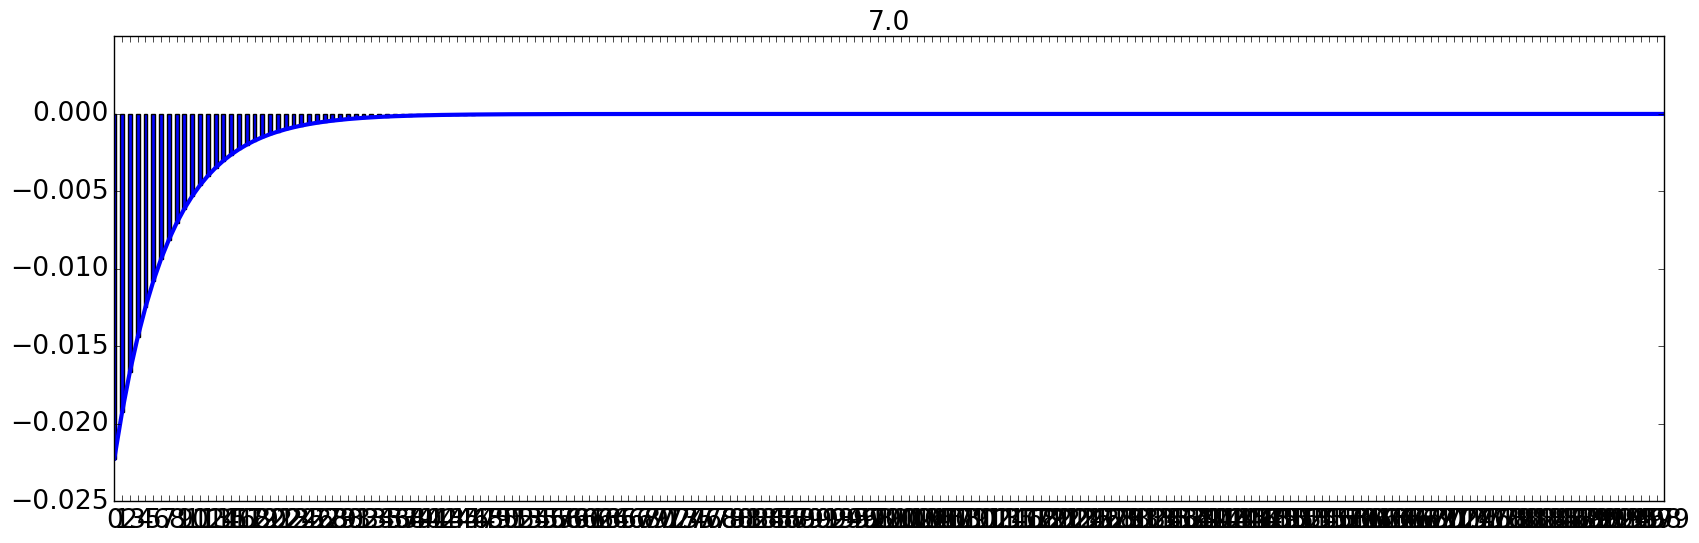

2     -0.000002
4     -0.000011
6     -0.000044
8     -0.001651
12    -0.029217
16    -0.000116
24    -0.000027
32    -0.000015
48    -0.000009
64    -0.000006
96    -0.000004
192   -0.000001
dtype: float64


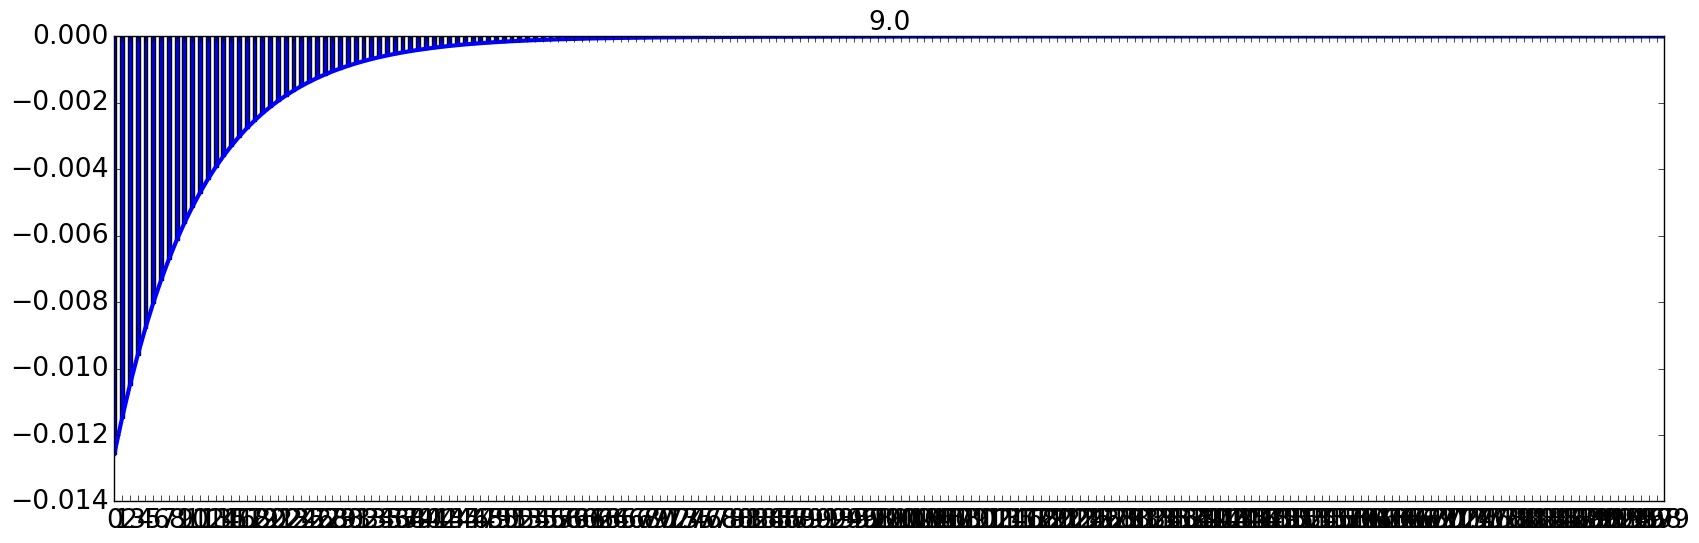

2     -6.075670e-07
4     -1.719710e-06
6     -3.231083e-06
8     -4.963743e-06
12    -1.771078e-05
16    -1.358777e-02
24    -2.379424e-04
32    -1.915339e-05
48    -7.129433e-06
64    -5.054621e-06
96    -3.630551e-06
192   -2.237666e-06
dtype: float64


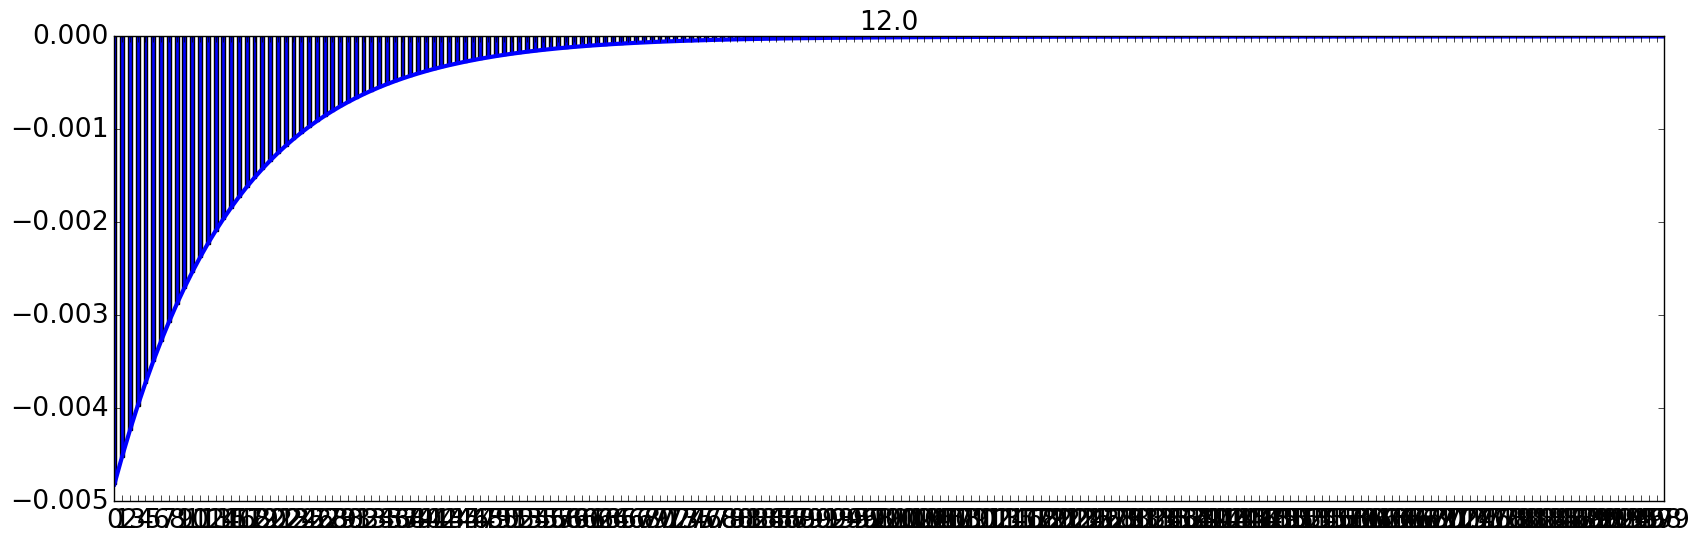

2     -0.000002
4     -0.000004
6     -0.000008
8     -0.000012
12    -0.000027
16    -0.000061
24    -0.000214
32    -0.000144
48    -0.000053
64    -0.000035
96    -0.000024
192   -0.000016
dtype: float64


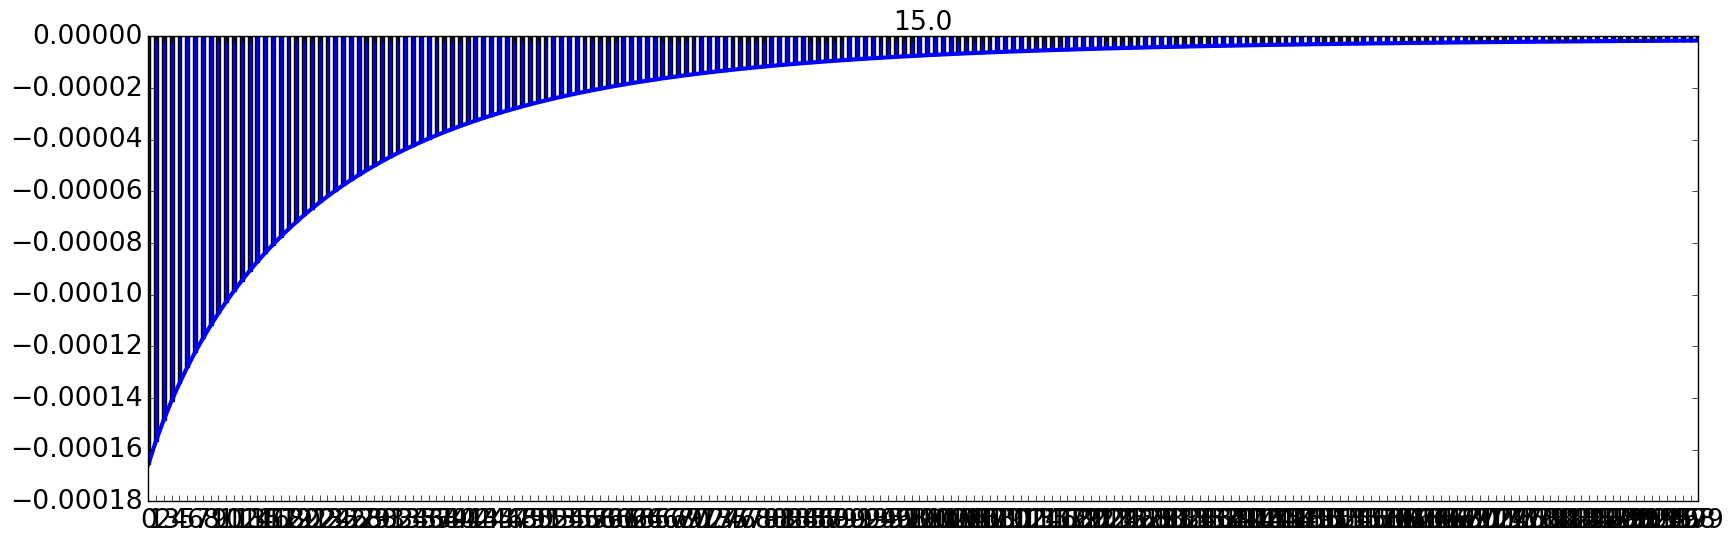

In [12]:
t_weight = dict()
for lamb in [0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 12.0, 15.0]:
    weights = pd.Series(index=periods, data=ar(A.values, D, r.values, lamb=lamb))
    print(weights.transpose())
    t_weight[lamb] = (W*weights).sum(axis=1)
    t_weight[lamb].plot(kind="bar")
    t_weight[lamb].plot()
    plt.title(lamb)
    plt.show()

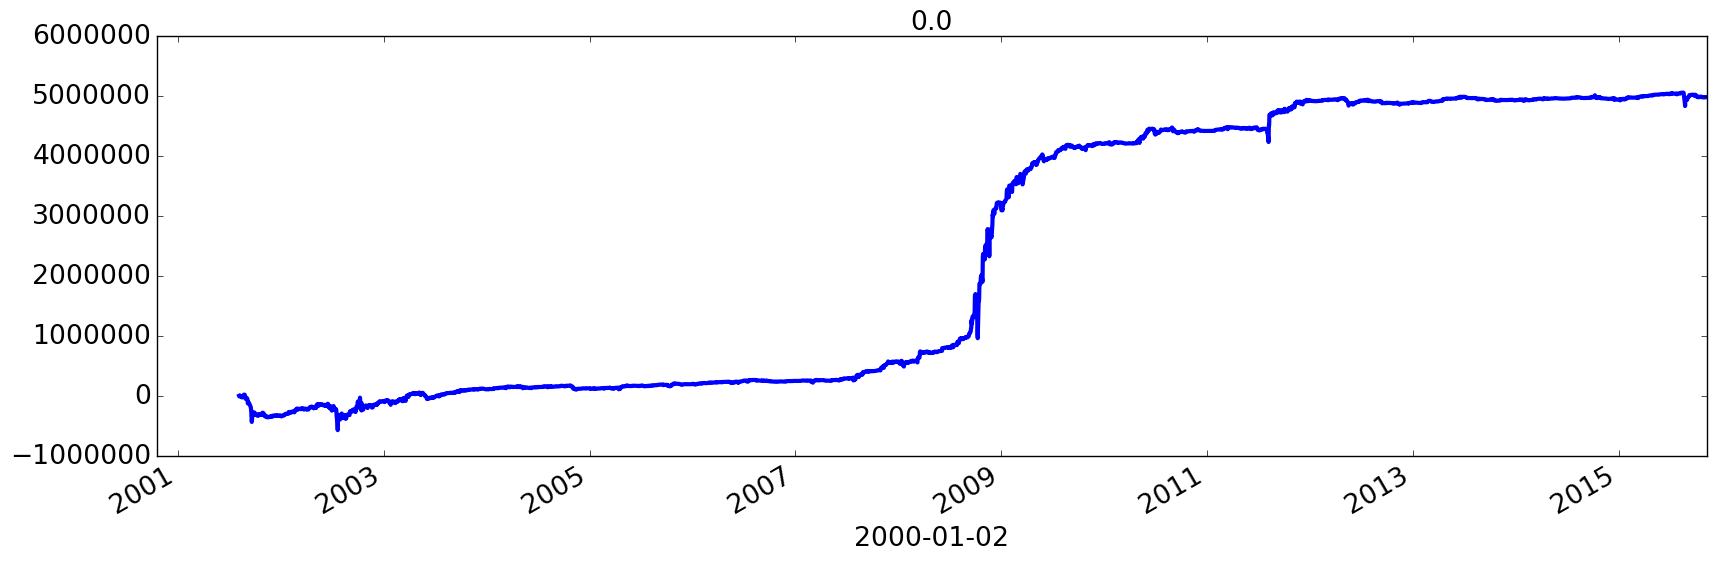

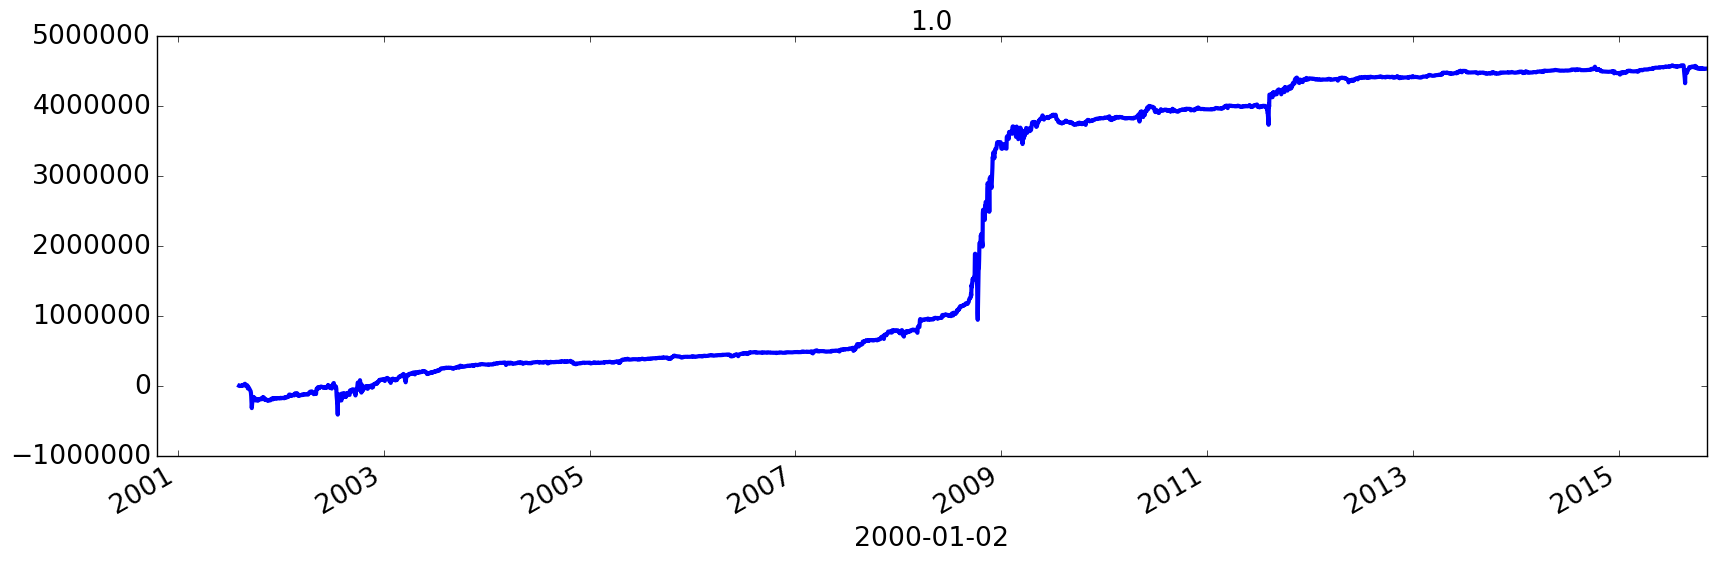

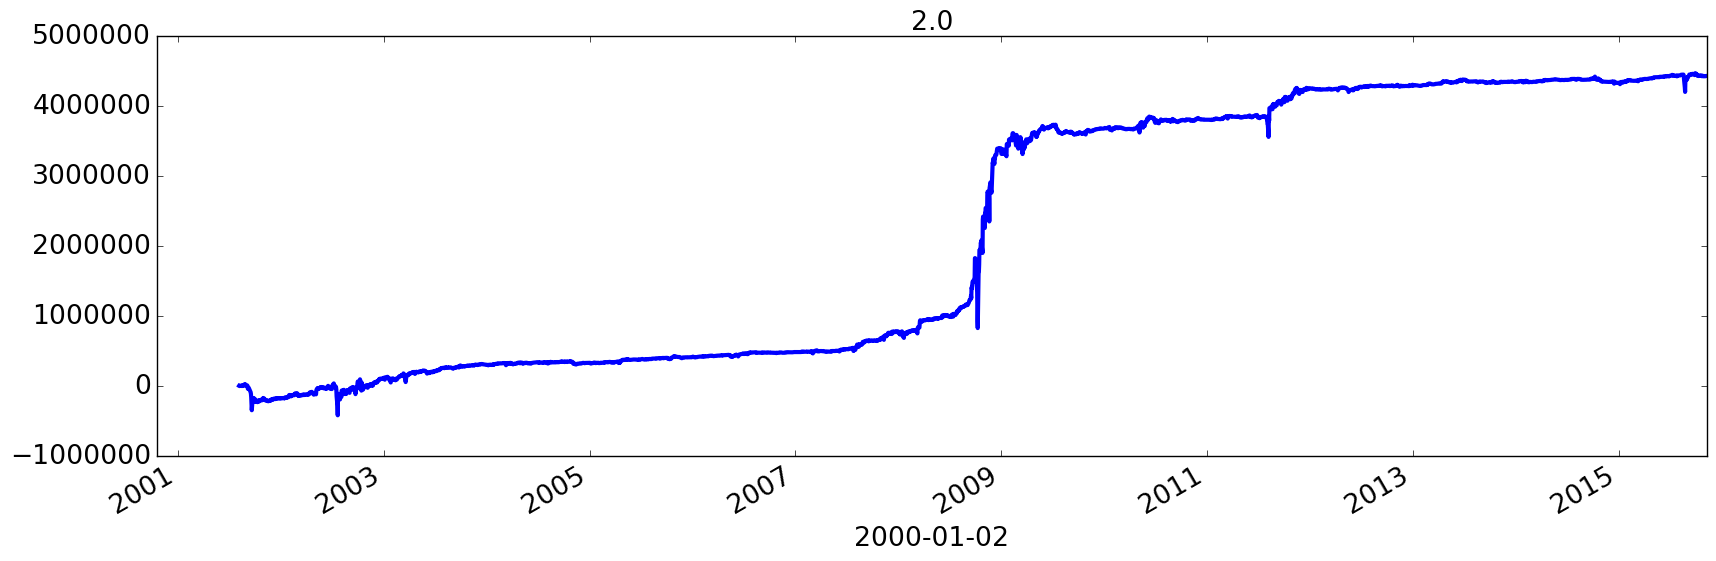

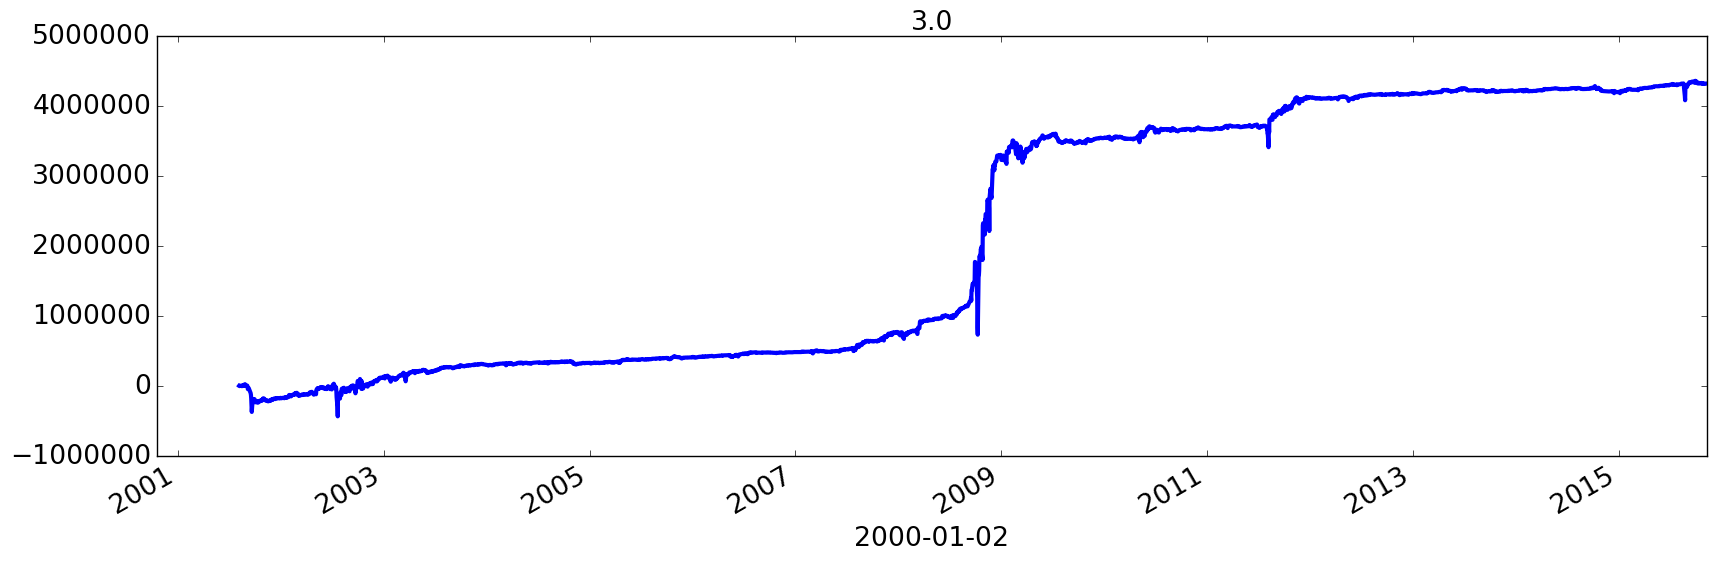

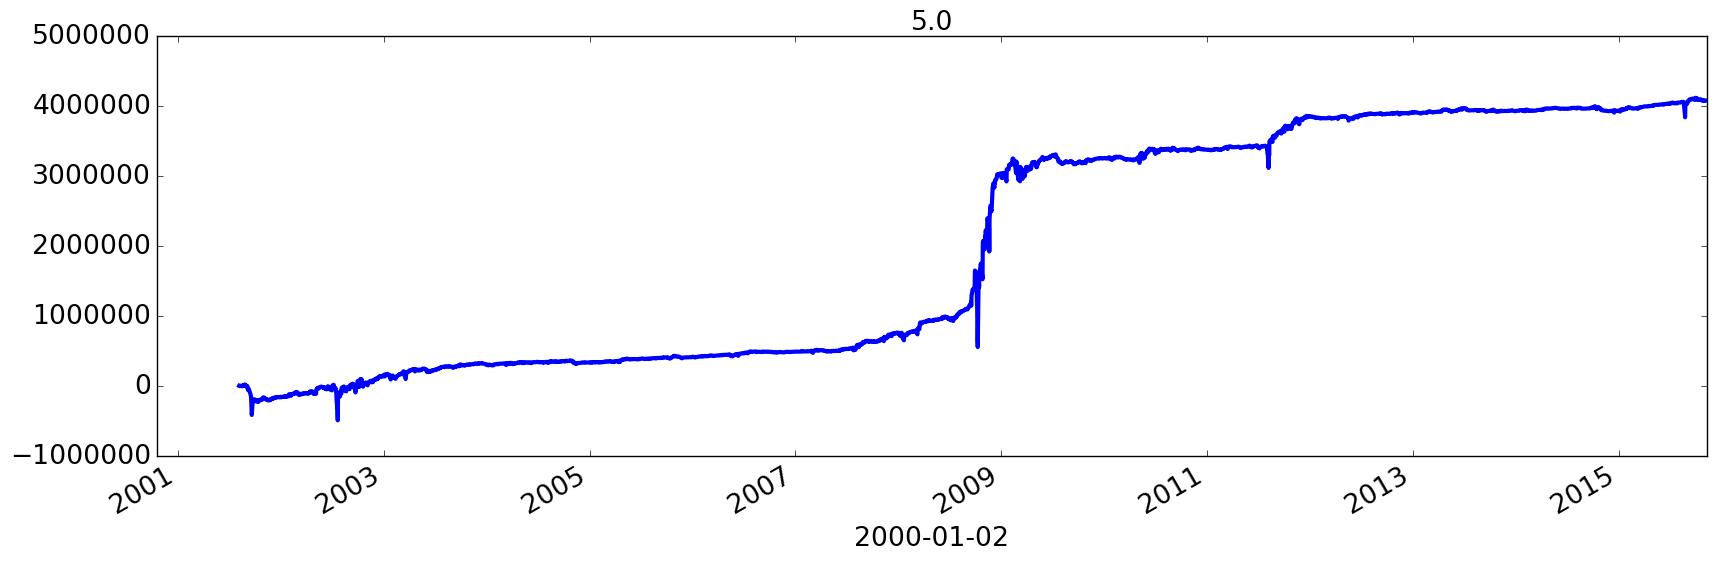

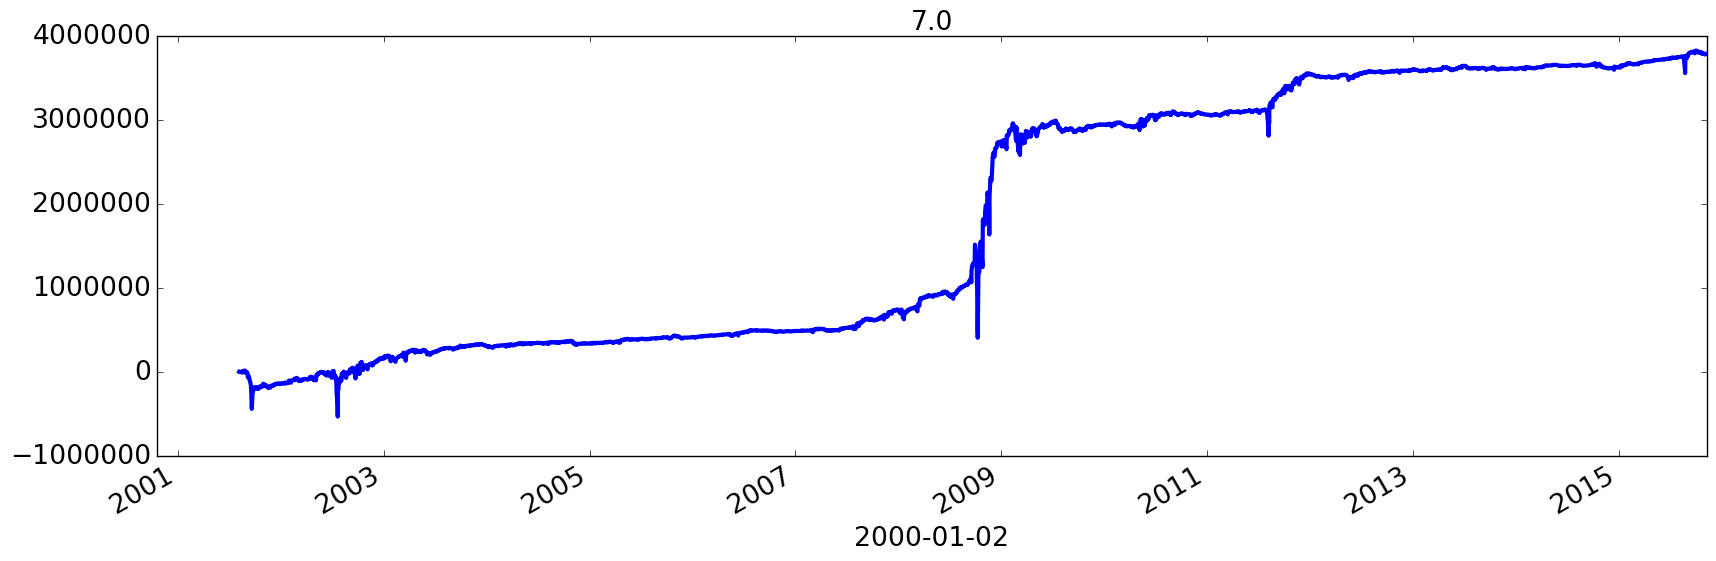

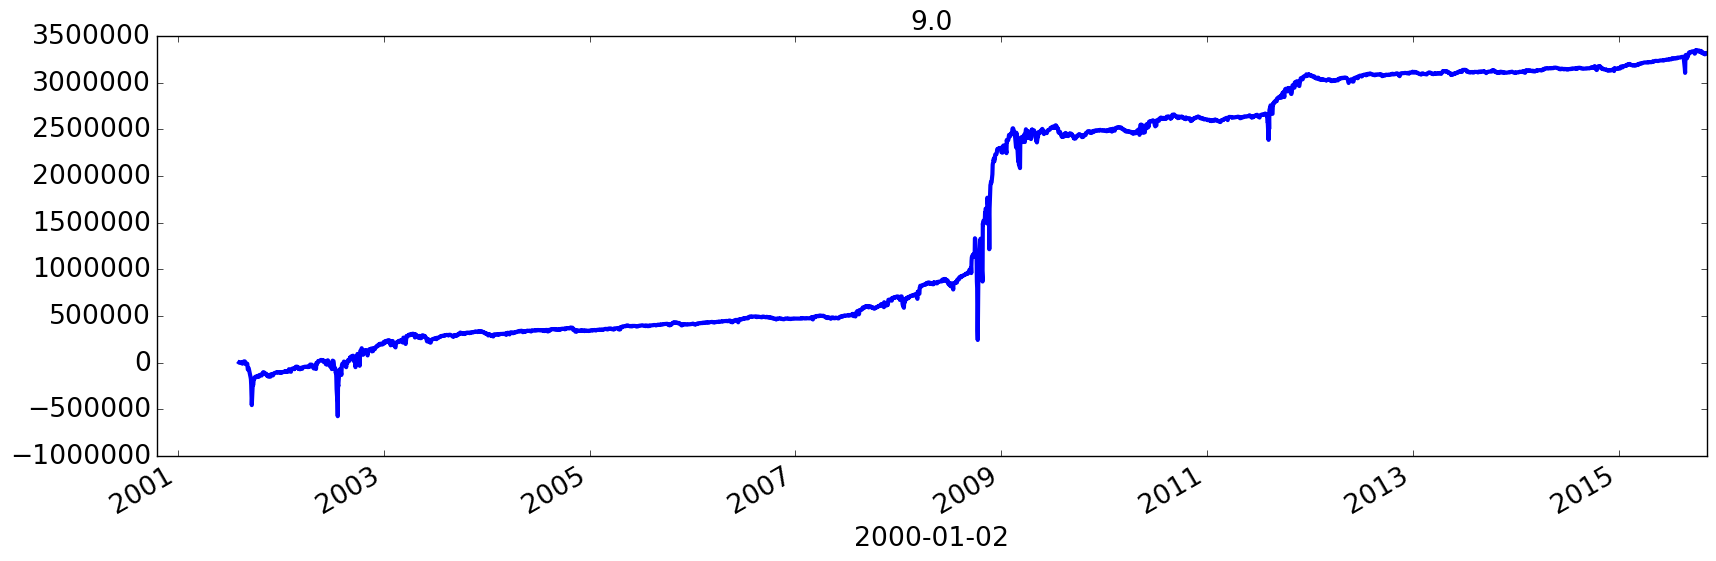

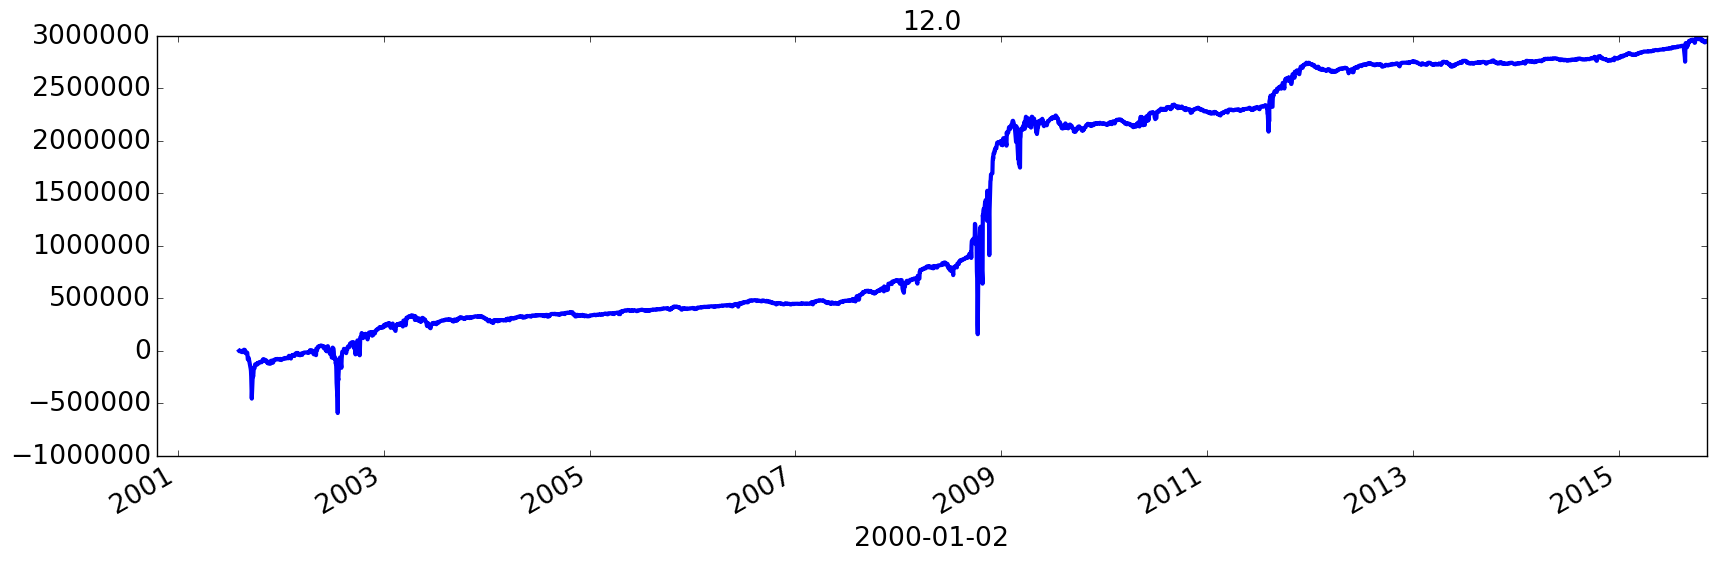

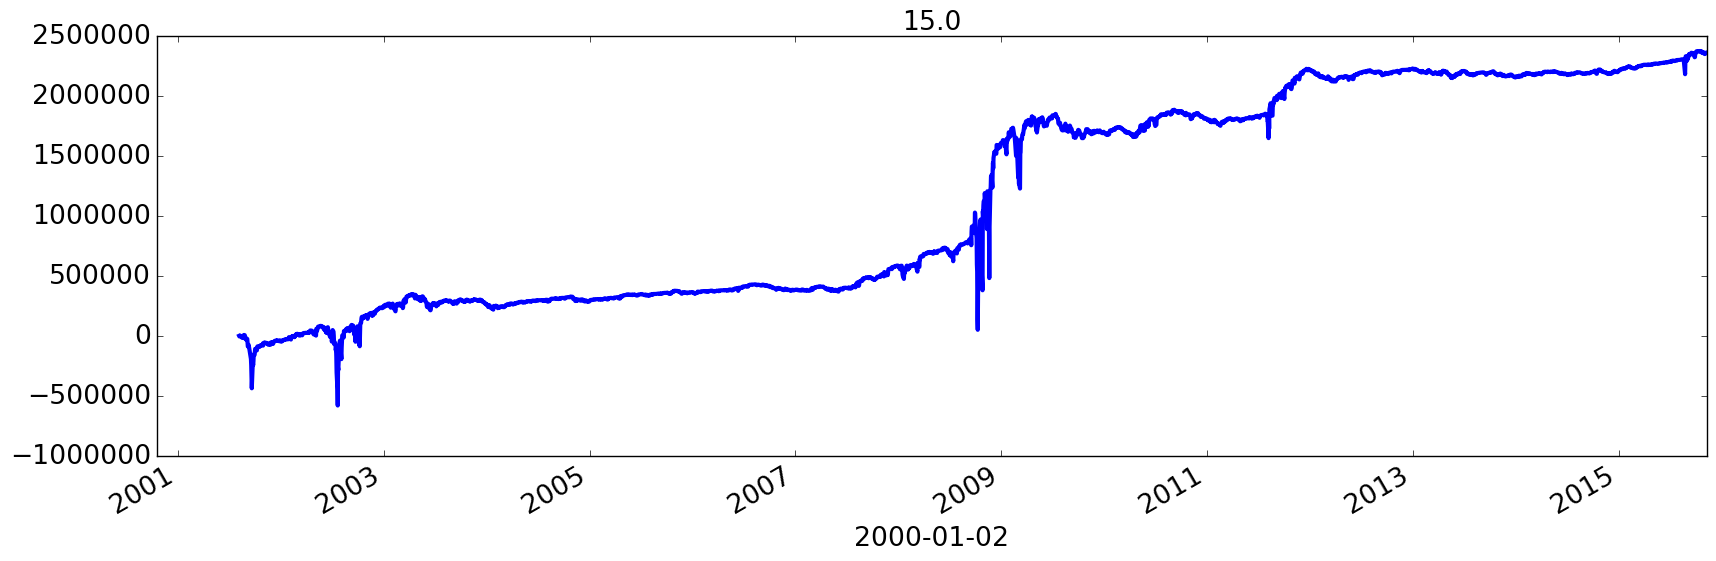

In [13]:
for lamb in sorted(t_weight.keys()):
    pos = convolution(r, t_weight[lamb])
    pos = 1e6*(pos/pos.std())
    (r*pos.shift(1)).cumsum().plot()
    plt.title(lamb)
    plt.show()

In [14]:
d = A.apply(mean_variation)
D = np.diag(d)
weights = pd.Series(index=periods, data=ar(A.values, D, r.values, lamb=3.0))
print(weights)
# let's make the first two moving averages really expensive!

d = A.apply(mean_variation)
D = np.diag(d)
D[0,0] = 100*D[0,0]
D[1,1] = 100*D[1,1]
a = pd.Series(index=periods, data=ar(A.values, D, r.values, lamb=3.0))
print(a)

2     -1.416213e-05
4     -7.761505e-02
6     -5.524952e-05
8     -3.342969e-05
12    -4.137081e-05
16    -6.474388e-05
24    -2.339135e-05
32    -9.797724e-06
48    -3.150517e-06
64     2.649569e-08
96     6.528326e-06
192    1.931073e-03
dtype: float64
2     -4.513791e-10
4     -6.248137e-10
6     -7.922599e-02
8     -2.576655e-05
12    -1.482075e-05
16    -1.366816e-05
24    -1.220329e-05
32    -9.428104e-06
48    -3.807375e-06
64     2.299780e-07
96     7.488475e-06
192    7.290993e-03
dtype: float64


### Summary

- The problem of constructing an estimator is corresponds to tracking an index. The index is here a historic return time series. The **assets** are standard estimators. 


- Using the (mean) total variation of the signals can help to prefer slower signals rather than expensive fast signals.


- Using a penalty induced by the $1$-norm (see LARS, LASSO) it is possible to establish a ranking amongst the indicators and construct them robustly. 


- It is possible to (vertical) stack the resulting systems to find optimal weights across a group of assets.